In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms

import os
from PIL import Image

class WeldingDefectDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = os.listdir(images_dir)  # List all files in the image directory
        self.transform = transform

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_file)
        
        # Check if image file exists
        if not os.path.exists(image_path):
            # print(f"Image not found: {image_path}. Skipping this entry.")
            return self.__getitem__((idx + 1) % len(self.image_files))  # Recursively try the next item

        # Load the image
        image = Image.open(image_path).convert('RGB')  # Or 'L' for grayscale
        

        # Find the corresponding label file
        label_file = image_file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(self.labels_dir, label_file)
        
        # Make sure the label file exists
        if not os.path.exists(label_path):
            raise FileNotFoundError(f"Label not found: {label_path}")

        label = self.load_label(label_path)  # Load the label
        
        if self.transform:
            image = self.transform(image)

        return image, label

    def load_label(self, label_path):
        with open(label_path, 'r') as file:
            # Read the first line and split into parts
            label_data = file.readline().strip().split()
            
            # Extract the class ID and convert class 2 to 1 for binary classification
            class_id = int(label_data[0])
            if class_id == 2:
                class_id = 1  # Convert class 2 to 1 for binary classification
            
            return class_id
    def __len__(self):
        # Return the number of images in the dataset
        return len(self.image_files)


# Define your transformations (resize and normalization)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Define your dataset for training, validation, and testing
train_dataset = WeldingDefectDataset(
    images_dir='C:/Users/nani0/Desktop/WeldingDefectDetection/DataSet/TheWeldingDefectDataset-v2/train/images',
    labels_dir='C:/Users/nani0/Desktop/WeldingDefectDetection/DataSet/TheWeldingDefectDataset-v2/train/labels',
    transform=transform
)

valid_dataset = WeldingDefectDataset(
    images_dir='C:/Users/nani0/Desktop/WeldingDefectDetection/DataSet/TheWeldingDefectDataset-v2/valid/images',
    labels_dir='C:/Users/nani0/Desktop/WeldingDefectDetection/DataSet/TheWeldingDefectDataset-v2/valid/labels',
    transform=transform
)

test_dataset = WeldingDefectDataset(
    images_dir='C:/Users/nani0/Desktop/WeldingDefectDetection/DataSet/TheWeldingDefectDataset-v2/test/images',
    labels_dir='C:/Users/nani0/Desktop/WeldingDefectDetection/DataSet/TheWeldingDefectDataset-v2/test/labels',
    transform=transform
)
# DataLoader for batching and shuffling
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [2]:
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels: {labels}")
    break


Batch of images shape: torch.Size([32, 3, 64, 64])
Batch of labels: tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 1])


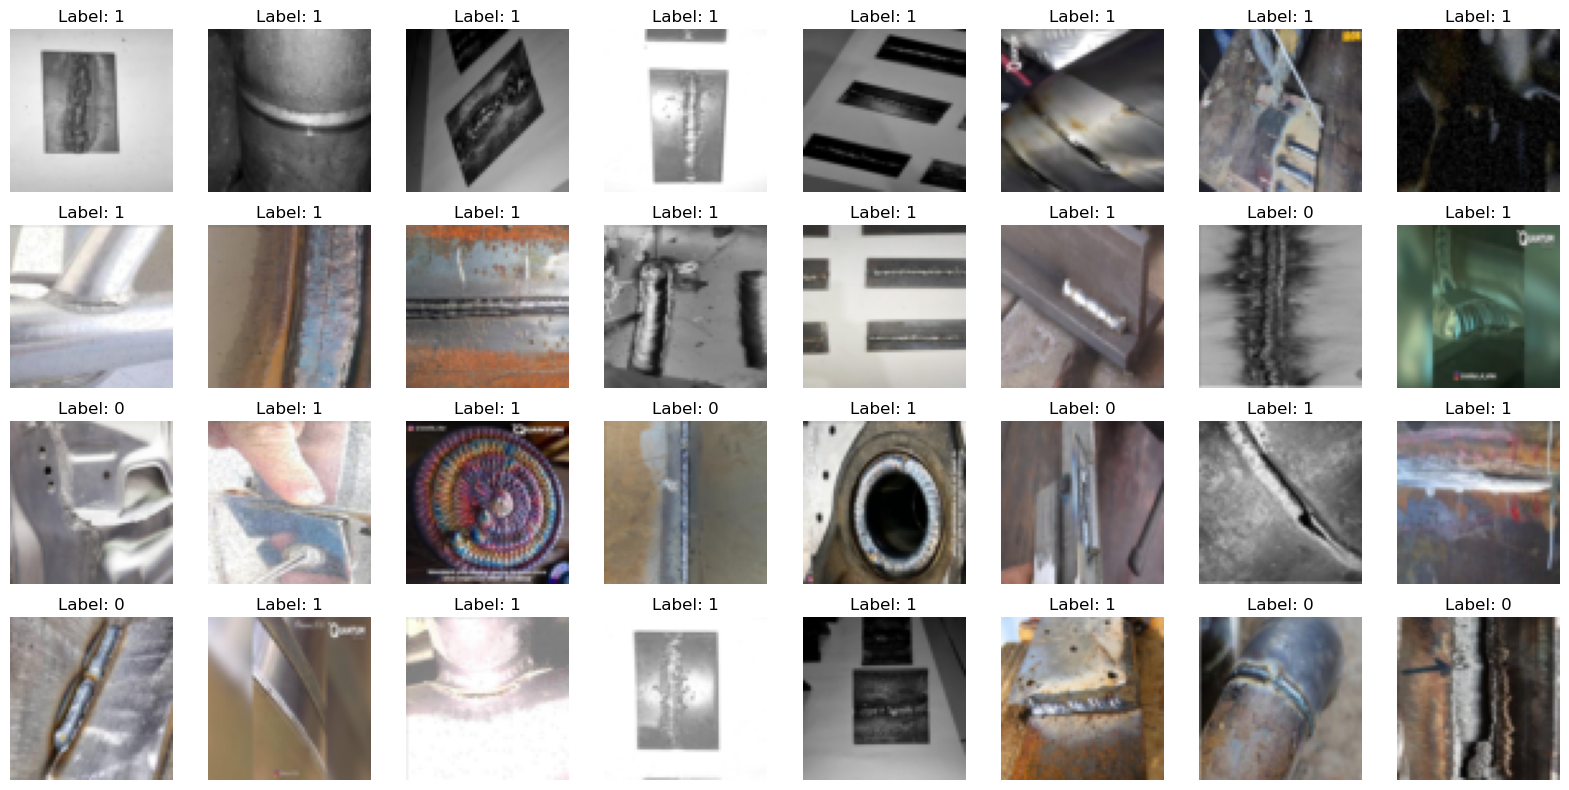

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(images, labels, batch_size=32):
    # Convert tensor to numpy array
    images = images.numpy().transpose((0, 2, 3, 1))  # Change shape from (batch_size, 3, 64, 64) to (batch_size, 64, 64, 3)
    
    # Set up the plot with the correct number of images
    # For batch_size 32, we'll show 8 images per row
    rows = 4  # Adjust this depending on the number of images per row
    cols = 8  # Adjust this depending on the batch size and number of images per row
    fig, axes = plt.subplots(rows, cols, figsize=(16, 8))  # Adjust the figure size accordingly
    
    # Loop through the batch and plot each image
    for i in range(batch_size):
        ax = axes[i // cols, i % cols]  # Determine the position of the image in the grid
        ax.imshow(images[i])  # Show the image
        ax.set_title(f"Label: {labels[i].item()}")  # Display label below the image
        ax.axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()


# Get the first batch
images, labels = next(iter(train_loader))

# Plot the first batch
imshow(images, labels, batch_size=32)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Define the architecture
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 input channels (RGB), 32 output channels
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 kernel
        
        self.dropout_conv = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Fully connected layer (adjust dimensions based on image size)
        self.dropout = nn.Dropout(p=0.5)  # Dropout
        self.fc2 = nn.Linear(128, 1)  # Output layer with 1 neuron for binary classification

    def forward(self, x):
        # Apply convolutional layers with activation functions
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)
        
        # Flatten the tensor
        x = x.view(-1, 64 * 16 * 16)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        # x = torch.sigmoid(x)   not needed as we are using BCEWithLogitsLoss
        return x

# Instantiate the model
model = CNNModel()


In [5]:
# Loss function (BCEWithLogitsLoss for binary classification)
criterion = nn.BCEWithLogitsLoss()

# Optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels.float())

            loss.backward()
            optimizer.step()

            predicted = (outputs > 0.5).float()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct_predictions / total_predictions
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}% ")

    return train_losses, train_accuracies

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=25)


Epoch [1/25], Loss: 0.8784, Accuracy: 69.86% 
Epoch [2/25], Loss: 0.4428, Accuracy: 74.31% 
Epoch [3/25], Loss: 0.4192, Accuracy: 75.79% 
Epoch [4/25], Loss: 0.4091, Accuracy: 76.59% 
Epoch [5/25], Loss: 0.3848, Accuracy: 76.78% 
Epoch [6/25], Loss: 0.3716, Accuracy: 79.68% 
Epoch [7/25], Loss: 0.3573, Accuracy: 81.78% 
Epoch [8/25], Loss: 0.3485, Accuracy: 80.61% 
Epoch [9/25], Loss: 0.3271, Accuracy: 82.71% 
Epoch [10/25], Loss: 0.3044, Accuracy: 84.13% 
Epoch [11/25], Loss: 0.3019, Accuracy: 83.76% 
Epoch [12/25], Loss: 0.2867, Accuracy: 84.93% 
Epoch [13/25], Loss: 0.2856, Accuracy: 85.55% 
Epoch [14/25], Loss: 0.2762, Accuracy: 87.40% 
Epoch [15/25], Loss: 0.2501, Accuracy: 88.51% 
Epoch [16/25], Loss: 0.2537, Accuracy: 87.96% 
Epoch [17/25], Loss: 0.2377, Accuracy: 88.94% 
Epoch [18/25], Loss: 0.2437, Accuracy: 88.14% 
Epoch [19/25], Loss: 0.2141, Accuracy: 89.68% 
Epoch [20/25], Loss: 0.2286, Accuracy: 89.68% 
Epoch [21/25], Loss: 0.2156, Accuracy: 89.19% 
Epoch [22/25], Loss: 0

In [7]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_losses = []
    val_accuracies = []

    correct_predictions_valid = 0
    total_predictions_valid = 0
    running_loss_valid = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels.float())

            predicted = (outputs > 0.5).float()
            correct_predictions_valid += (predicted == labels).sum().item()
            total_predictions_valid += labels.size(0)

            running_loss_valid += loss.item()

    avg_loss = running_loss_valid / len(valid_loader)
    accuracy = 100 * correct_predictions_valid / total_predictions_valid
    val_losses.append(avg_loss)
    val_accuracies.append(accuracy)
    val_losses.append(running_loss_valid)
    val_accuracies.append(accuracy)
    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

    return val_losses, val_accuracies

# Ensure the device setup is done before calling the validation function.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the correct device
val_losses, val_accuracy = validate_model(model, valid_loader, criterion)

Validation Loss: 0.4427, Validation Accuracy: 86.93%


In [8]:
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    correct_predictions_test = 0
    total_predictions_test = 0
    running_loss_test = 0.0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():  # No gradients needed for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device

            # Forward pass
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels.float())  # Ensure labels are float for BCEWithLogitsLoss

            # Apply threshold for binary classification
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            predicted = (probs > 0.5).float()

            # Collect data for analysis and visualization
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # Calculate test accuracy
            correct_predictions_test += (predicted == labels).sum().item()
            total_predictions_test += labels.size(0)

            running_loss_test += loss.item()

    # Calculate final test accuracy
    accuracy_test = 100 * correct_predictions_test / total_predictions_test

    return {
        "test_loss": running_loss_test / len(test_loader),
        "test_accuracy": accuracy_test,
        "labels": all_labels,
        "predictions": all_predictions,
        "probabilities": all_probs,
    }
    
    
# Ensure device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Call the test function
test_results = test_model(model, test_loader, criterion, device)

# Print test metrics
print(f"Test Loss: {test_results['test_loss']:.4f}")
print(f"Test Accuracy: {test_results['test_accuracy']:.2f}%")

# Access predictions and labels for further analysis or plotting
labels = test_results["labels"]
predictions = test_results["predictions"]
probabilities = test_results["probabilities"]



Test Loss: 0.6086
Test Accuracy: 82.54%


In [9]:
torch.save(model.state_dict(), 'model.pth')
print("Model saved successfully!")


Model saved successfully!


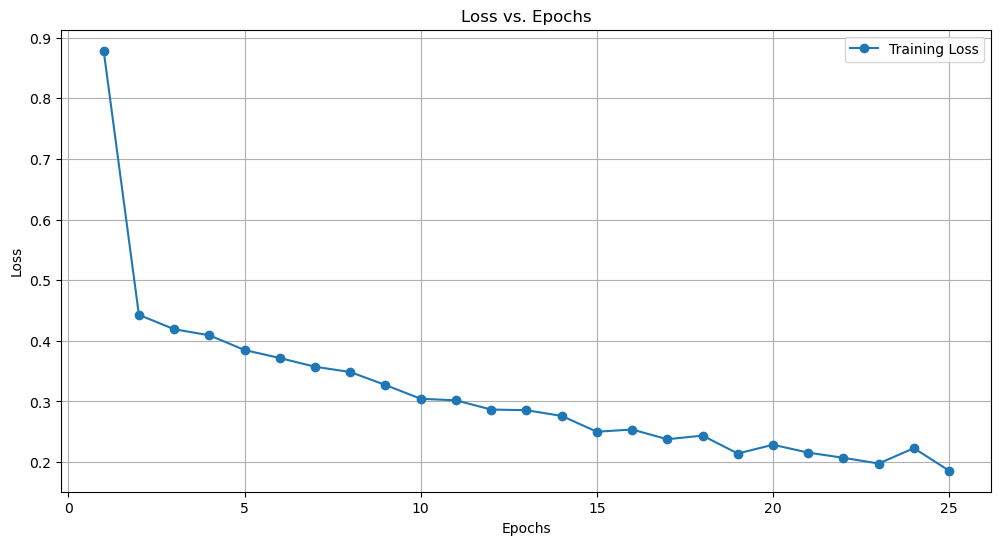

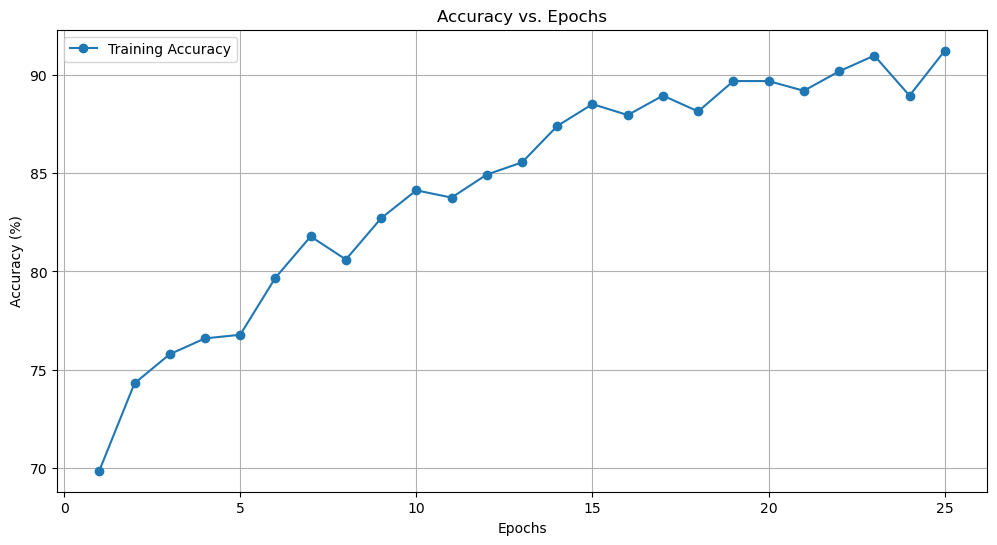

In [10]:
# Assuming the following lists contain data recorded during training:
# train_losses, train_accuracies

epochs = range(1, len(train_losses) + 1)  # Create a range for the number of epochs

# Plot Loss vs. Epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy vs. Epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()

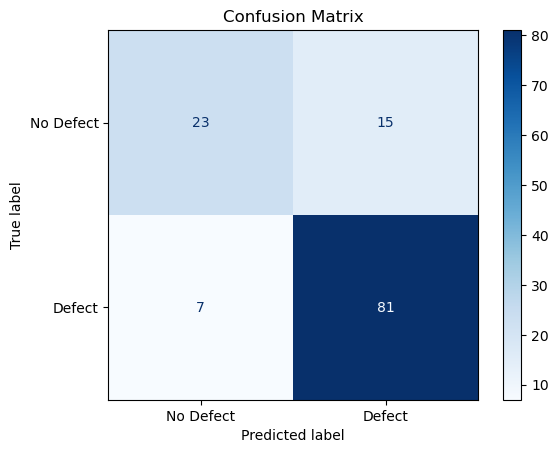

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Defect", "Defect"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


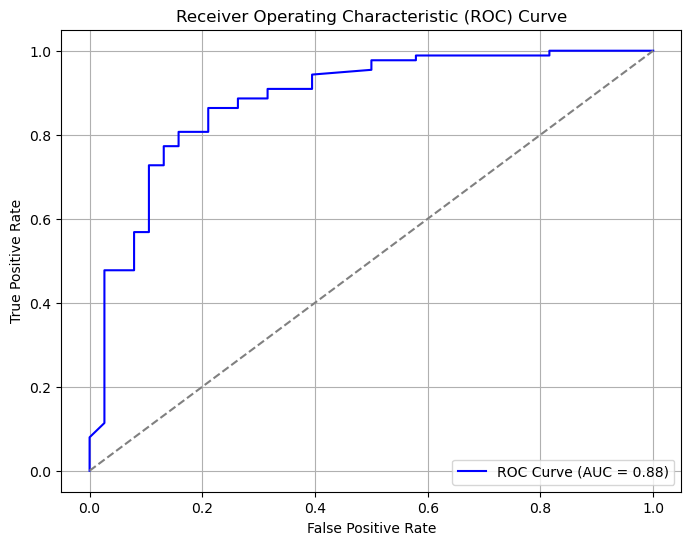

In [12]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(labels, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


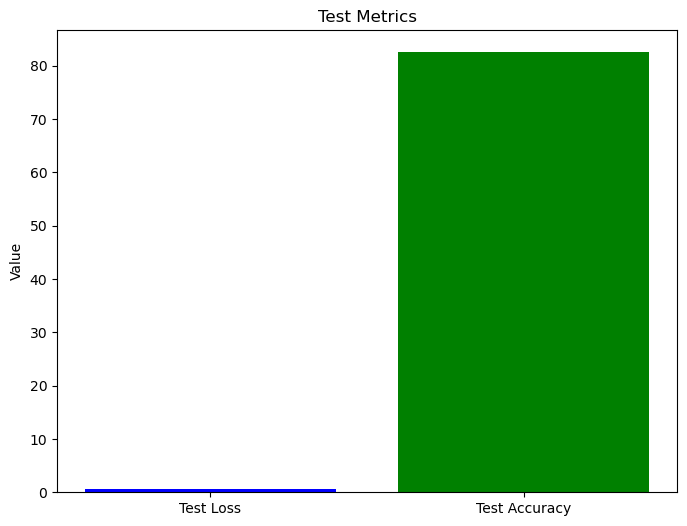

In [13]:
plt.figure(figsize=(8, 6))
metrics = ['Test Loss', 'Test Accuracy']
values = [test_results['test_loss'], test_results['test_accuracy']]

plt.bar(metrics, values, color=['blue', 'green'])
plt.title('Test Metrics')
plt.ylabel('Value')
plt.show()

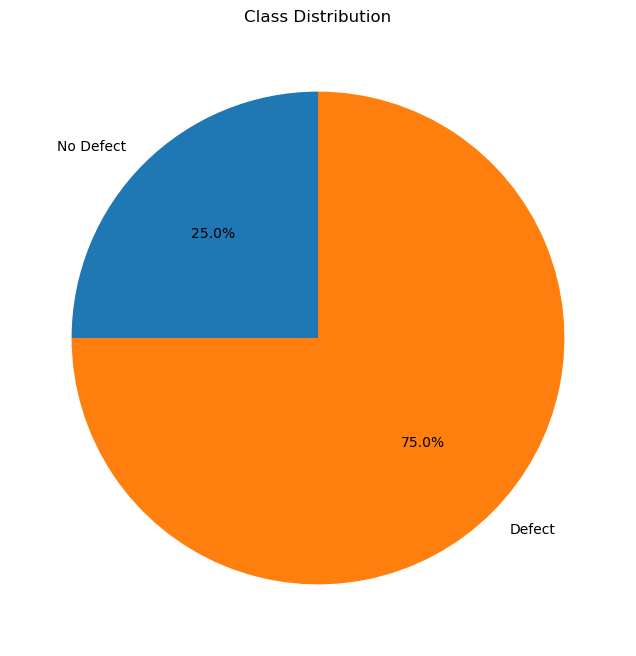

In [14]:
import numpy as np

# Example class distribution
class_counts = [500, 1500]  # Replace with actual counts for each class
class_labels = ['No Defect', 'Defect']

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')
plt.show()


In [15]:
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    correct_predictions_test = 0
    total_predictions_test = 0
    running_loss_test = 0.0

    with torch.no_grad():  # No gradients needed for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels.float())

            # Calculate test accuracy
            predicted = (outputs > 0.5).float()
            correct_predictions_test += (predicted == labels).sum().item()
            total_predictions_test += labels.size(0)

            running_loss_test += loss.item()

    # Calculate test accuracy
    accuracy_test = 100 * correct_predictions_test / total_predictions_test
    return running_loss_test / len(test_loader), accuracy_test


In [16]:
evaluator = CNNModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluator.to(device)

evaluator.load_state_dict(torch.load('model.pth'))

C:\Users\nani0\AppData\Local\Temp\ipykernel_45768\3695704854.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  evaluator.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

In [17]:
test_loss, test_accuracy = test_model(evaluator, test_loader,criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.6086
Test Accuracy: 81.75%
